In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

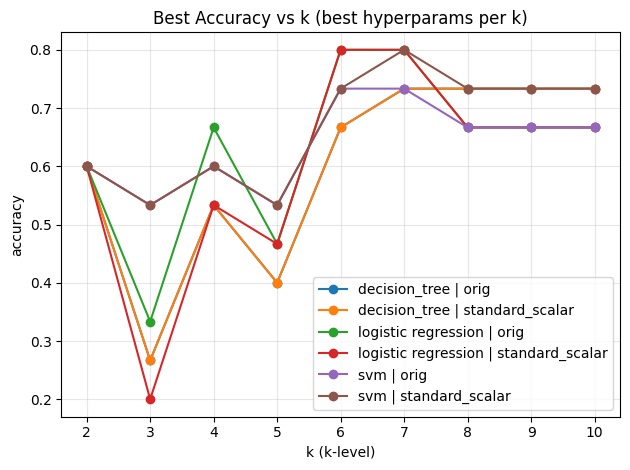

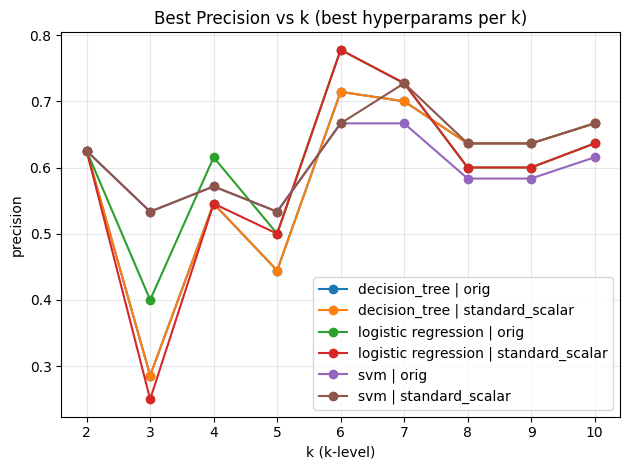

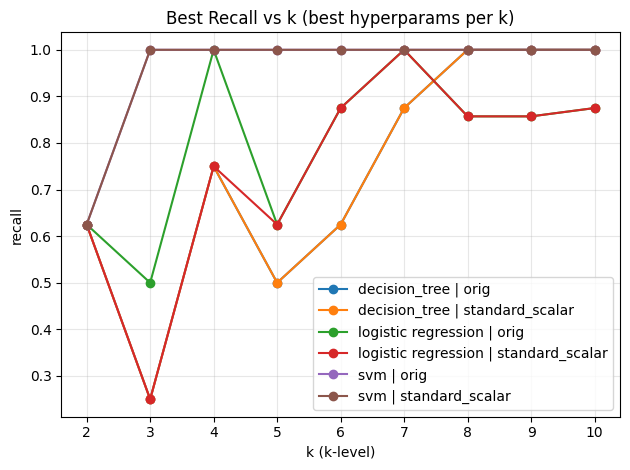

In [2]:
# load
# -----------------------------
df = pd.read_csv("results.csv")

# make sure k is numeric (your code currently saves it as string)
df["k-level"] = pd.to_numeric(df["k-level"], errors="coerce")

# keep only k-anonym results (optional, but likely what you want)
# df = df[df["anonymization type"].astype(str).str.startswith("k")]

# Define "hyperparameter combo"... include *all* hyperparam columns so combos are unique per model.
# -----------------------------
hyperparam_cols = [
    "logistic_reg_c", "lr_ratios",
    "nn_layers", "nn_neurons", "nn_batch_size", "nn_epochs",
    "dt_max_depth", "dt_min_samples_split",
    "svm_c_val", "svm_kernel",
    "knn_n_neighbor", "knn_metric",
    "gbm_learning_rate", "gbm_n_estimator",
]

# Only keep columns that exist
hyperparam_cols = [c for c in hyperparam_cols if c in df.columns]

# Base grouping keys
base_cols = ["k-level", "model used", "scalar_status"]

# This defines a "hyperparam combo"
combo_cols = base_cols + hyperparam_cols

# Best row per hyperparam combo (dedupe)
#    If you have multiple rows with same combo (e.g., repeats), keep the max-accuracy row.
#    Also keeps precision/recall from that winning row.
# -----------------------------
df = df.dropna(subset=["k-level", "accuracy"])  # basic safety

best_per_combo = df.loc[df.groupby(combo_cols, dropna=False)["accuracy"].idxmax()].copy()

# Best model per k (per model + scaler)
#    This picks the single best hyperparam combo at each k for each model/scaler.
# -----------------------------
best_per_k = best_per_combo.loc[
    best_per_combo.groupby(base_cols)["accuracy"].idxmax()
].copy()

# Sort for nicer plots
best_per_k = best_per_k.sort_values(["model used", "scalar_status", "k-level"])

# plot helper
# -----------------------------
def plot_metric(metric: str, title: str):
    plt.figure()
    for (model, scaler), g in best_per_k.groupby(["model used", "scalar_status"], dropna=False):
        g = g.sort_values("k-level")
        label = f"{model} | {scaler}"
        plt.plot(g["k-level"], g[metric], marker="o", label=label)

    plt.xlabel("k (k-level)")
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_metric("accuracy",  "Best Accuracy vs k (best hyperparams per k)")
plot_metric("precision", "Best Precision vs k (best hyperparams per k)")
plot_metric("recall",    "Best Recall vs k (best hyperparams per k)")
